In [13]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("../../data/kospi/price.csv", index_col = 'date', parse_dates = True)
sn = pd.read_csv("../../data/kospi/share_number.csv", index_col = 'date', parse_dates = True)
pm = pd.read_csv("../../data/kospi/price_mod.csv", index_col = 'date', parse_dates = True)


per_t = pd.read_csv("../../data/kospi/per.csv", index_col = 'date', parse_dates = True)
pbr_t = pd.read_csv("../../data/kospi/pbr.csv", index_col = 'date', parse_dates = True)
psr_t = pd.read_csv("../../data/kospi/psr.csv", index_col = 'date', parse_dates = True)
pcr_t = pd.read_csv("../../data/kospi/pcr.csv", index_col = 'date', parse_dates = True)

# 삼성전자 제외
del df['A005930'], sn['A005930'], pm['A005930'], per_t['A005930'], pbr_t['A005930'], psr_t['A005930'], pcr_t['A005930']

In [15]:
# 시가총액
market_cap = df * sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap = market_cap.groupby('date').last()

# 월간 수익률
pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

In [16]:
df.index = df.index + pd.tseries.offsets.MonthEnd(0)
m_df = df.groupby('date').last()
# 수정주가로 다시 계산, 시차고려
per = (m_pm / (m_df / per_t)).shift(15)
pbr = (m_pm / (m_df / pbr_t)).shift(15)
psr = (m_pm / (m_df / psr_t)).shift(15)
pcr = (m_pm / (m_df / pcr_t)).shift(15)

In [17]:
# 각 value factor마다 상위30% - 하위30% 의 누적수익률
per_rank = per.rank(axis=1, pct=True)
pbr_rank = pbr.rank(axis=1, pct=True)
psr_rank = psr.rank(axis=1, pct=True)
pcr_rank = pcr.rank(axis=1, pct=True)

per_win_mask = per_rank <= 0.3
per_lose_mask = per_rank > 0.7
pbr_win_mask = pbr_rank <= 0.3
pbr_lose_mask = pbr_rank > 0.7
psr_win_mask = psr_rank <= 0.3
psr_lose_mask = psr_rank > 0.7
pcr_win_mask = pcr_rank <= 0.3
pcr_lose_mask = pcr_rank > 0.7

win_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [per_win_mask, pbr_win_mask, psr_win_mask, pcr_win_mask]]
lose_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [per_lose_mask, pbr_lose_mask, psr_lose_mask, pcr_lose_mask]]

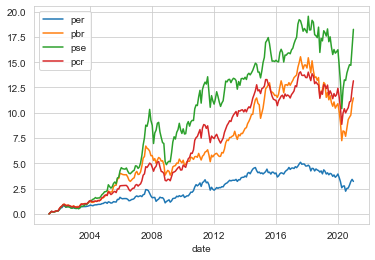

In [18]:
# 이전 달의 시가총액으로 투자 (cap_weight.shift(1))
per_win_cr = ((m_ret * win_cap_weight[0].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
per_lose_cr = ((m_ret * lose_cap_weight[0].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
pbr_win_cr = ((m_ret * win_cap_weight[1].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
pbr_lose_cr = ((m_ret * lose_cap_weight[1].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
psr_win_cr = ((m_ret * win_cap_weight[2].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
psr_lose_cr = ((m_ret * lose_cap_weight[2].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
pcr_win_cr = ((m_ret * win_cap_weight[3].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
pcr_lose_cr = ((m_ret * lose_cap_weight[3].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]

sns.set_style('whitegrid')
sns.lineplot(per_win_cr.index, per_win_cr - per_lose_cr, label='per')
sns.lineplot(pbr_win_cr.index, pbr_win_cr - pbr_lose_cr, label='pbr')
sns.lineplot(psr_win_cr.index, psr_win_cr - psr_lose_cr, label='pse')
sns.lineplot(pcr_win_cr.index, pcr_win_cr - pcr_lose_cr, label='pcr')
plt.show()

In [19]:
# 각 value factor에 대해 rank를 정하고 z score를 구한 뒤 총 rank 구하기
# 총 rank에 대해 분위수 별로 포트폴리오 구성
per_z = ((per_rank.T - per_rank.mean(axis=1)) / per_rank.std(axis=1))
pbr_z = ((pbr_rank.T - pbr_rank.mean(axis=1)) / pbr_rank.std(axis=1))
psr_z = ((psr_rank.T - psr_rank.mean(axis=1)) / psr_rank.std(axis=1))
pcr_z = ((pcr_rank.T - pcr_rank.mean(axis=1)) / pcr_rank.std(axis=1))

total_z = per_z.T + pbr_z.T + psr_z.T + pcr_z.T
total_z = ((total_z.T - total_z.mean(axis=1)) / total_z.std(axis=1)).T
total_rank = total_z.rank(axis=1, pct=True)

p1_mask = total_rank <= 0.2
p2_mask = (total_rank > 0.2) & (total_rank <= 0.4)
p3_mask = (total_rank > 0.4) & (total_rank <= 0.6)
p4_mask = (total_rank > 0.6) & (total_rank <= 0.8)
p5_mask = (total_rank > 0.8) & (total_rank <= 1.0)

cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]

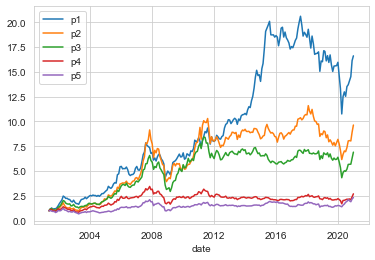

In [20]:
p1_cr = ((m_ret * cap_weight[0].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p2_cr = ((m_ret * cap_weight[1].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p3_cr = ((m_ret * cap_weight[2].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p4_cr = ((m_ret * cap_weight[3].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p5_cr = ((m_ret * cap_weight[4].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]

sns.set_style('whitegrid')
sns.lineplot(p1_cr.index, p1_cr, label = 'p1')
sns.lineplot(p2_cr.index, p2_cr, label = 'p2')
sns.lineplot(p3_cr.index, p3_cr, label = 'p3')
sns.lineplot(p4_cr.index, p4_cr, label = 'p4')
sns.lineplot(p5_cr.index, p5_cr, label = 'p5')
plt.show()

In [21]:
# 시총 하위 30% 기업에 대해 조사
m_cap_weight = m_cap.rank(axis=1, pct=1) > 0.7
m_cap = m_cap[m_cap_weight]
m_ret = m_ret[m_cap_weight]
per = per[m_cap_weight]
pbr = pbr[m_cap_weight]
psr = psr[m_cap_weight]
pcr = pcr[m_cap_weight]

In [22]:
# 각 value factor에 대해 rank를 정하고 z score를 구한 뒤 총 rank 구하기
# 총 rank에 대해 분위수 별로 포트폴리오 구성
per_z = ((per_rank.T - per_rank.mean(axis=1)) / per_rank.std(axis=1))
pbr_z = ((pbr_rank.T - pbr_rank.mean(axis=1)) / pbr_rank.std(axis=1))
psr_z = ((psr_rank.T - psr_rank.mean(axis=1)) / psr_rank.std(axis=1))
pcr_z = ((pcr_rank.T - pcr_rank.mean(axis=1)) / pcr_rank.std(axis=1))

total_z = per_z.T + pbr_z.T + psr_z.T + pcr_z.T
total_z = ((total_z.T - total_z.mean(axis=1)) / total_z.std(axis=1)).T
total_rank = total_z.rank(axis=1, pct=True)

p1_mask = total_rank <= 0.2
p2_mask = (total_rank > 0.2) & (total_rank <= 0.4)
p3_mask = (total_rank > 0.4) & (total_rank <= 0.6)
p4_mask = (total_rank > 0.6) & (total_rank <= 0.8)
p5_mask = (total_rank > 0.8) & (total_rank <= 1.0)

cap_weight = [(m_cap[i].T / m_cap[i].sum(axis=1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]

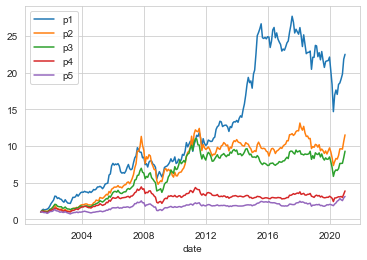

In [23]:
p1_cr = ((m_ret * cap_weight[0].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p2_cr = ((m_ret * cap_weight[1].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p3_cr = ((m_ret * cap_weight[2].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p4_cr = ((m_ret * cap_weight[3].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]
p5_cr = ((m_ret * cap_weight[4].shift(1)).sum(axis = 1) + 1).cumprod()[15:-1]

sns.set_style('whitegrid')
sns.lineplot(p1_cr.index, p1_cr, label = 'p1')
sns.lineplot(p2_cr.index, p2_cr, label = 'p2')
sns.lineplot(p3_cr.index, p3_cr, label = 'p3')
sns.lineplot(p4_cr.index, p4_cr, label = 'p4')
sns.lineplot(p5_cr.index, p5_cr, label = 'p5')
plt.show()